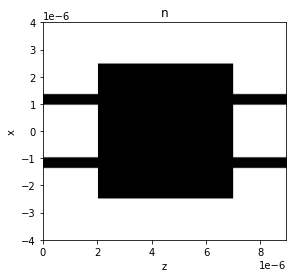

In [1]:
import emepy
from emepy.eme import Layer, EME
from emepy.mode import Mode
from emepy.fd import MSEMpy
import numpy as np
from matplotlib import pyplot as plt
from emepy.tools import Si, SiO2

# Geometric parameters
wavelength = 1.55e-6 # Wavelength
num_inputs = 2
num_outputs = 2
input_width = 0.4*1e-6
output_width = 0.4*1e-6
input_gap = 2*1e-6
output_gap = 2*1e-6
input_length = 2*1e-6
output_length = 2*1e-6
mmi_width = 5*1e-6
mmi_length = 5*1e-6
thickness = 0.22*1e-6
mesh=100 # Number of mesh points
core_index=Si(wavelength*1e6) # Silicon core
cladding_index=SiO2(wavelength*1e6) # Oxide cladding
num_modes_mmi = 2
num_modes_channels = 1
x = np.linspace(-4e-6,4e-6,mesh)

# Create simulation 
eme = EME()

# Create input
starting_center = -0.5*(num_inputs-1)*(input_gap+input_width)
n_input = np.ones(mesh) * cladding_index
for inp in range(num_inputs):
    center = starting_center + inp*(input_gap+input_width)
    left_edge = (center-0.5*input_width)
    right_edge = (center+0.5*input_width)
    n_input = np.where((left_edge <= x) * (x <= right_edge), core_index, n_input)

input_channel = MSEMpy(
    wavelength,
    width=None,
    thickness=thickness,
    cladding_index=cladding_index,
    num_modes=num_modes_channels,
    mesh=mesh,
    x=x,
    y=x,
    n=n_input
)

eme.add_layer(Layer(input_channel, num_modes_channels, wavelength, input_length))  

# Create mmi middle
n_middle = np.ones(mesh) * cladding_index
left_edge = -0.5*mmi_width
right_edge = 0.5*mmi_width
n_middle = np.where((left_edge <= x) * (x <= right_edge), core_index, n_middle)

middle = MSEMpy(
    wavelength,
    width=None,
    thickness=thickness,
    cladding_index=cladding_index,
    num_modes=num_modes_mmi,
    mesh=mesh,
    x=x,
    y=x,
    n=n_middle
)

eme.add_layer(Layer(middle, num_modes_mmi, wavelength, mmi_length)) 


# Create output
starting_center = -0.5*(num_inputs-1)*(input_gap+input_width)
n_output = np.ones(mesh) * cladding_index
for out in range(num_outputs):
    center = starting_center + out*(input_gap+output_width)
    left_edge = (center-0.5*output_width)
    right_edge = (center+0.5*output_width)
    n_output = np.where((left_edge <= x) * (x <= right_edge), core_index, n_output)

output_channel = MSEMpy(
    wavelength,
    width=None,
    thickness=thickness,
    cladding_index=cladding_index,
    num_modes=num_modes_channels,
    mesh=mesh,
    x=x,
    y=x,
    n=n_output
)

eme.add_layer(Layer(output_channel, num_modes_channels, wavelength, output_length))  

# Add a monitor
monitor = eme.add_monitor(axes="xyz")

# Visualize the layout
eme.draw()


In [2]:
eme.propagate()

# Implement spurious mode checker

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)